In [61]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from keras.src.optimizers import Adam
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from shap.plots import waterfall
from shap import Explanation
import shap

In [62]:
df_benign = pd.read_csv('Data/CSV_benign.csv', low_memory=False)
df_benign['label'] = 0

In [63]:
df_malware = pd.read_csv('Data/CSV_malware.csv', low_memory=False)
df_malware['label'] = 1

In [64]:
df_malware = df_malware[df_benign.columns]

In [65]:
merged_df = pd.concat([df_benign, df_malware], ignore_index=True)

In [66]:
percent_na = (merged_df.isna().sum() / len(merged_df)) * 100
columns_to_keep = percent_na[percent_na <= 30].index.tolist()
filtered_df = merged_df[columns_to_keep].copy()
filtered_df.dropna(axis=0, inplace=True)

In [67]:
filtered_df = filtered_df.drop(['Registrar', 'typos', 'char_distribution', '1gram', '2gram', '3gram','Creation_Date_Time','Domain','Domain_Name','IP','puny_coded','Page_Rank','dec_8','dec_32','shortened','oc_32','oc_8','hex_32','hex_8','obfuscate_at_sign'], axis=1)

In [68]:
filtered_df['Domain_Age'] = filtered_df['Domain_Age'].str.slice(0, 4)

In [69]:
count_ones = filtered_df['label'].value_counts().get(1, 0)

print("Number of occurrences of the value 1 in the label column':", count_ones)

Number of occurrences of the value 1 in the label column': 2877


In [70]:
count_zeros = filtered_df['label'].value_counts().get(0, 0)

print("Number of occurrences of the value 0 in the 'label' column':", count_zeros)

Number of occurrences of the value 0 in the 'label' column': 267360


In [71]:
value_counts = filtered_df['label'].value_counts()
total_count = len(filtered_df)
percent_ones = (value_counts.get(1, 0) / total_count) * 100
percent_zeros = (value_counts.get(0, 0) / total_count) * 100

print("Percentage occurrence of value 1 in the 'label' column:", round(percent_ones, 3), "%")
print("Percentage occurrence of the value 0 in the 'label' column:", round(percent_zeros, 3), "%")

Percentage occurrence of value 1 in the 'label' column: 1.065 %
Percentage occurrence of the value 0 in the 'label' column: 98.935 %


In [72]:
filtered_df.dtypes

Country                object
ASN                   float64
TTL                    object
Alexa_Rank             object
subdomain              object
len                    object
longest_word           object
entropy                object
Domain_Age             object
tld                    object
numeric_percentage     object
sld                    object
Name_Server_Count      object
label                   int64
dtype: object

In [73]:
filtered_df['ASN'] = pd.to_numeric(filtered_df['ASN'], errors='coerce')
filtered_df['len'] = pd.to_numeric(filtered_df['len'], errors='coerce')
filtered_df['TTL'] = pd.to_numeric(filtered_df['TTL'], errors='coerce')
filtered_df['entropy'] = pd.to_numeric(filtered_df['entropy'], errors='coerce')
filtered_df['Domain_Age'] = pd.to_numeric(filtered_df['Domain_Age'], errors='coerce')
filtered_df['numeric_percentage'] = pd.to_numeric(filtered_df['numeric_percentage'], errors='coerce')
filtered_df['Name_Server_Count'] = pd.to_numeric(filtered_df['Name_Server_Count'], errors='coerce')
filtered_df['subdomain'] = pd.to_numeric(filtered_df['subdomain'], errors='coerce')

filtered_df = filtered_df.dropna(subset=['ASN'])
filtered_df = filtered_df.dropna(subset=['len'])
filtered_df = filtered_df.dropna(subset=['TTL'])
filtered_df = filtered_df.dropna(subset=['entropy'])
filtered_df = filtered_df.dropna(subset=['Domain_Age'])
filtered_df = filtered_df.dropna(subset=['numeric_percentage'])
filtered_df = filtered_df.dropna(subset=['subdomain'])
filtered_df = filtered_df.dropna(subset=['Name_Server_Count'])
filtered_df

,Country,ASN,TTL,Alexa_Rank,subdomain,len,longest_word,entropy,Domain_Age,tld,numeric_percentage,sld,Name_Server_Count,label
0,US,15169.0,46.0,1.0,0.0,7.0,google,1.834876,8256.0,com,0.000000,google,8.0,0
5,IE,32934.0,264.0,4.0,0.0,9.0,facebook,2.595489,8426.0,com,0.000000,facebook,4.0,0
7,IE,32934.0,299.0,4.0,0.0,9.0,facebook,2.595489,8426.0,com,0.000000,facebook,4.0,0
8,IE,32934.0,3218.0,4.0,1.0,12.0,facebook,2.723308,8426.0,com,0.000000,facebook,4.0,0
10,US,15169.0,95.0,2.0,0.0,8.0,youtube,2.375000,5546.0,com,0.000000,youtube,8.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499125,HU,197248.0,3599.0,-1.0,0.0,10.0,globo,2.314247,2257.0,org,0.000000,globocomm,2.0,1
499126,HU,197248.0,3598.0,-1.0,0.0,10.0,globo,2.314247,2257.0,org,0.000000,globocomm,2.0,1
499127,HU,197248.0,3599.0,-1.0,1.0,13.0,globo,2.530423,2257.0,org,0.000000,globocomm,2.0,1
499128,NL,204915.0,3599.0,3851.0,1.0,22.0,p,3.642649,1440.0,com,17.857143,000webhostapp,4.0,1


In [74]:
train, temp = train_test_split(filtered_df, test_size=0.3)
valid, test = train_test_split(temp, test_size=1/3)

In [75]:
label_encoder = LabelEncoder()
columns_to_encode = filtered_df[['Country', 'longest_word', 'tld', 'sld', 'Name_Server_Count']]

# not to smuggle knowledge from 1 to 2 dataset

for col in columns_to_encode:
    if not pd.api.types.is_numeric_dtype(filtered_df[col]):
        train[col] = train[col].astype(str)
        train[col] = label_encoder.fit_transform(train[col])
        
        test[col] = test[col].astype(str)
        test[col] = label_encoder.fit_transform(test[col])
        
        valid[col] = valid[col].astype(str)
        valid[col] = label_encoder.fit_transform(valid[col])

train.isna().sum()


Country               0
ASN                   0
TTL                   0
Alexa_Rank            0
subdomain             0
len                   0
longest_word          0
entropy               0
Domain_Age            0
tld                   0
numeric_percentage    0
sld                   0
Name_Server_Count     0
label                 0
dtype: int64

In [76]:
scaler = MinMaxScaler()
scaler_train_df = scaler.fit_transform(train)
scaler_test_df = scaler.fit_transform(test)
scaler_valid_df = scaler.fit_transform(valid)


scaler_train_df = pd.DataFrame(scaler_train_df, columns=train.columns)
scaler_test_df = pd.DataFrame(scaler_test_df, columns=test.columns)
scaler_valid_df = pd.DataFrame(scaler_valid_df, columns=valid.columns)

scaler_train_df

,Country,ASN,TTL,Alexa_Rank,subdomain,len,longest_word,entropy,Domain_Age,tld,numeric_percentage,sld,Name_Server_Count,label
0,0.458564,0.040932,0.036249,0.991000,0.0,0.125000,0.428374,0.663673,0.467802,0.196581,0.000000,0.916223,9.687850e-10,0.0
1,0.596685,0.043870,0.004529,0.000000,0.0,0.100000,0.996635,0.640371,0.237200,0.196581,0.000000,0.993825,9.687850e-10,0.0
2,0.966851,0.066639,0.001508,0.000000,0.0,0.075000,0.146228,0.515587,0.080839,0.196581,0.000000,0.152635,4.843925e-10,0.0
3,0.966851,0.049228,0.009060,0.000000,0.0,0.033333,0.605055,0.433970,0.789779,0.196581,0.264463,0.603598,9.687850e-10,0.0
4,0.961326,0.072316,0.009060,0.000000,0.0,0.158333,0.438554,0.749758,0.218688,0.769231,0.000000,0.442832,4.843925e-10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133381,0.966851,0.033535,0.000753,0.020660,0.0,0.091667,0.831040,0.607315,0.381351,0.196581,0.000000,0.326429,4.843925e-10,0.0
133382,0.966851,0.117223,0.036249,0.008190,1.0,0.066667,0.995341,0.468658,0.632729,0.196581,0.000000,0.932104,4.843925e-10,0.0
133383,0.966851,0.048119,0.009060,0.018942,0.0,0.033333,0.437648,0.433970,0.392477,0.636752,0.000000,0.441476,9.687850e-10,0.0
133384,0.519337,0.113213,0.054375,0.000000,1.0,0.116667,0.483673,0.569702,0.289287,0.196581,0.000000,0.491906,1.937570e-09,0.0


In [77]:
X = train.drop('label', axis=1)
y = train['label']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X, y)

feature_importances = rf_classifier.feature_importances_

importance_df = pd.DataFrame({'Column': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

threshold = 0.10
selected_columns = importance_df.loc[importance_df['Importance'] >= threshold, 'Column'].tolist()

print("Selected columns:", selected_columns)

Selected columns: ['Domain_Age', 'sld', 'longest_word', 'entropy', 'ASN']


In [78]:
feature_importances

array([0.04181297, 0.10464316, 0.06165943, 0.05526713, 0.01454783,
       0.07608245, 0.13396243, 0.10869073, 0.16694252, 0.0307415 ,
       0.02464678, 0.14983114, 0.03117194])

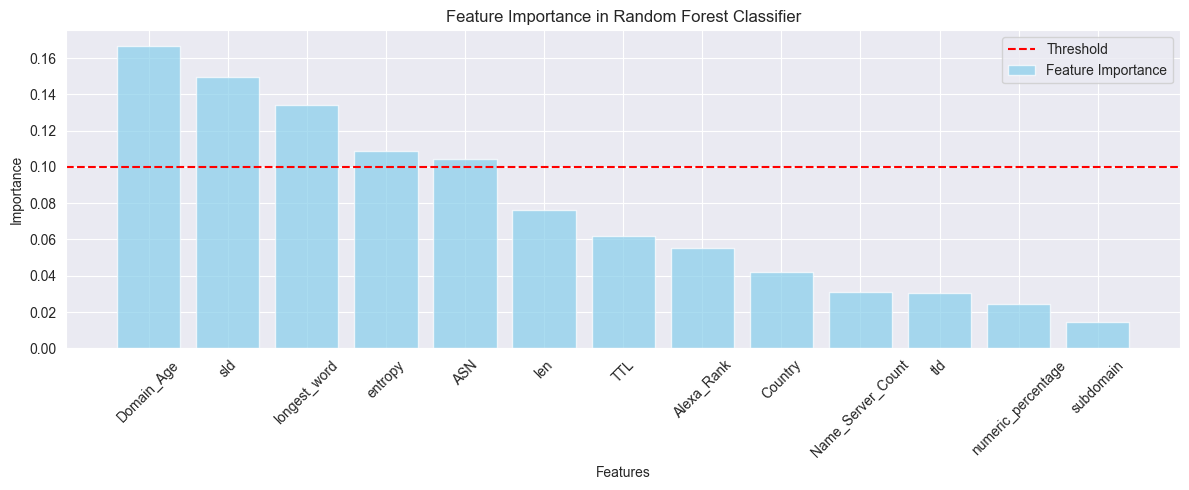

In [79]:
plt.figure(figsize=(12, 5))
plt.bar(importance_df['Column'], importance_df['Importance'], color='skyblue', alpha=0.7, label='Feature Importance')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

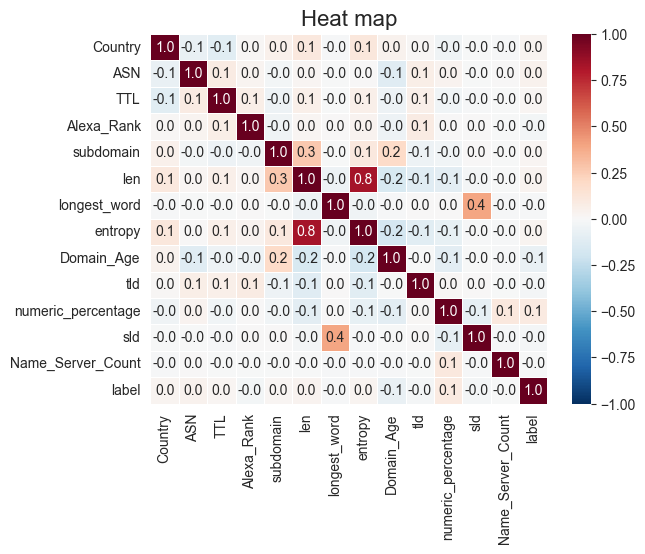

In [80]:

corr_matrix = test.corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    fmt='.1f',
)
plt.title('Heat map', fontsize=16)
plt.show() 

In [81]:
def balance_data(X_part, y_part):
    X_bal, y_bal = SMOTETomek(sampling_strategy='auto').fit_resample(X_part, y_part)
    return X_bal, y_bal

In [82]:
selected_columns =['Domain_Age', 'sld', 'longest_word', 'entropy', 'ASN','len']

In [83]:
X_train = train[selected_columns]
y_train = train.iloc[:,-1]

In [84]:
X_train, y_train = balance_data(X_train, y_train)

In [85]:
X_test = test[selected_columns]
y_test = test.iloc[:, -1]

In [86]:
X_test, y_test = balance_data(X_test, y_test)

In [87]:
X_valid = valid[selected_columns]
y_valid = valid.iloc[:,-1]

In [88]:
X_valid, y_valid = balance_data(X_valid, y_valid)

In [89]:
knn = KNeighborsClassifier(n_neighbors=7, metric='manhattan')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/700 [00:00<?, ?it/s]

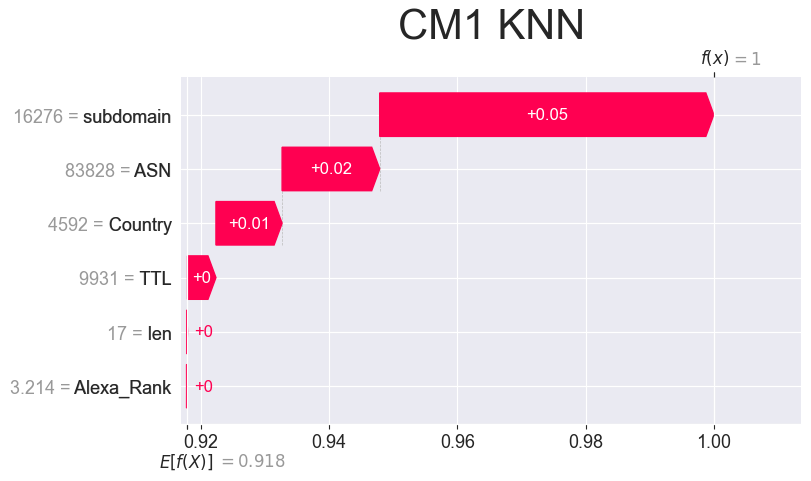

[[1. 0.]]


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


In [90]:
shap.initjs()
num_samples = 700

explainer = shap.KernelExplainer(knn.predict_proba, X_train.iloc[:num_samples, :])
sv = explainer.shap_values(X_train.iloc[:num_samples, :])
exp = Explanation(sv[0], explainer.expected_value[0], X_train.iloc[:num_samples, :], feature_names=X.columns)

plt.title("CM1 KNN", fontsize=30)
idx = 0
waterfall(exp[idx])
print(knn.predict_proba(X_train.iloc[[idx]].values))

In [91]:
c_matrix = confusion_matrix(y_test, y_pred)

acc_score = accuracy_score(y_test, y_pred)
print('Acc_score: ', round(acc_score, 3))

auc_score = roc_auc_score(y_test, y_pred)
print('AUC-org :', round(auc_score, 3))

g_mean = geometric_mean_score(y_test, y_pred)
print('G_mean: ', round(g_mean, 3))

f1_score_val = f1_score(y_test, y_pred)
print('f1_score: ', round(f1_score_val, 3))

sensitivity = c_matrix[1, 1] / (c_matrix[1, 1] + c_matrix[1, 0])
print('Sensitivity : ', round(sensitivity, 3))

specificity = c_matrix[0, 0] / (c_matrix[0, 1] + c_matrix[0, 0])
print('Specificity : ', round(specificity, 3))

precision_score_val = precision_score(y_test, y_pred)
print('Prec-org :', round(precision_score_val, 3))

Acc_score:  0.591
AUC-org : 0.591
G_mean:  0.518
f1_score:  0.428
Sensitivity :  0.306
Specificity :  0.876
Prec-org : 0.711


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

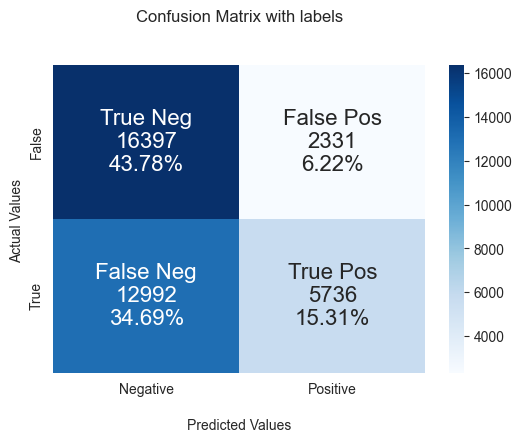

In [92]:
import numpy as np

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     c_matrix.flatten() / np.sum(c_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.heatmap(c_matrix, annot=labels, cmap='Blues', fmt='', annot_kws={"size": 16})

ax.set_title('Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['False', 'True'])

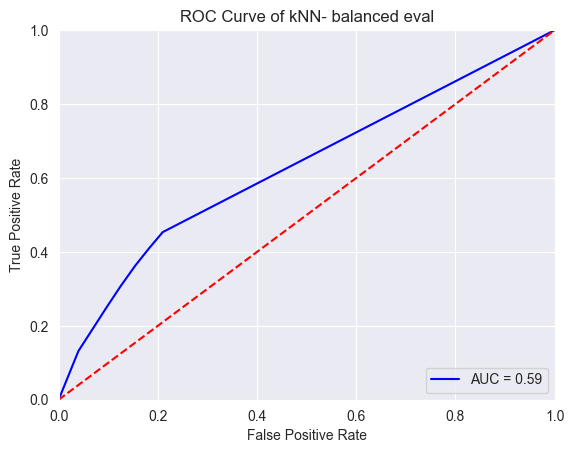

In [93]:
y_scores = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % auc_score)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN- balanced eval')
plt.show()

In [94]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/700 [00:00<?, ?it/s]

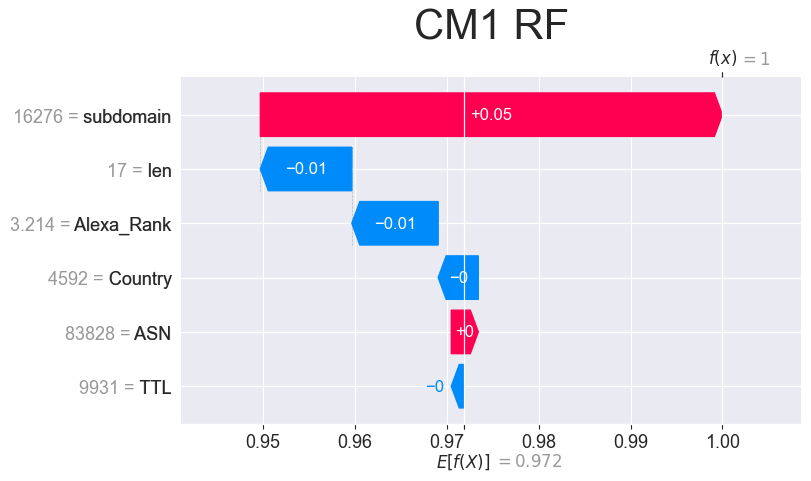

[[1. 0.]]


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [95]:
num_samples = 700

explainer = shap.KernelExplainer(rf.predict_proba, X_train.iloc[:num_samples, :])
sv = explainer.shap_values(X_train.iloc[:num_samples, :])
exp = Explanation(sv[0], explainer.expected_value[0], X_train.iloc[:num_samples, :], feature_names=X.columns)

plt.title("CM1 RF", fontsize=30)
idx = 0
waterfall(exp[idx])
print(rf.predict_proba(X_train.iloc[[idx]].values))

In [96]:
c_matrix = confusion_matrix(y_test, y_pred)

acc_score = accuracy_score(y_test, y_pred)
print('Acc_score: ', round(acc_score, 3))

auc_score = roc_auc_score(y_test, y_pred)
print('AUC-org :', round(auc_score, 3))

g_mean = geometric_mean_score(y_test, y_pred)
print('G_mean: ', round(g_mean, 3))

f1_score_val = f1_score(y_test, y_pred)
print('f1_score: ', round(f1_score_val, 3))

sensitivity = c_matrix[1, 1] / (c_matrix[1, 1] + c_matrix[1, 0])
print('Sensitivity : ', round(sensitivity, 3))

specificity = c_matrix[0, 0] / (c_matrix[0, 1] + c_matrix[0, 0])
print('Specificity : ', round(specificity, 3))

precision_score_val = precision_score(y_test, y_pred)
print('Prec-org :', round(precision_score_val, 3))

Acc_score:  0.768
AUC-org : 0.768
G_mean:  0.735
f1_score:  0.702
Sensitivity :  0.546
Specificity :  0.99
Prec-org : 0.981


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

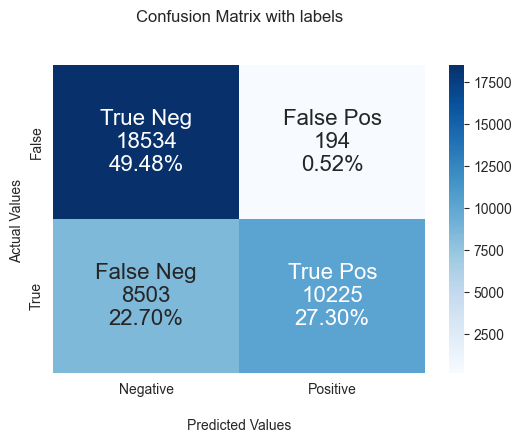

In [97]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     c_matrix.flatten() / np.sum(c_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.heatmap(c_matrix, annot=labels, cmap='Blues', fmt='', annot_kws={"size": 16})

ax.set_title('Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['False', 'True'])

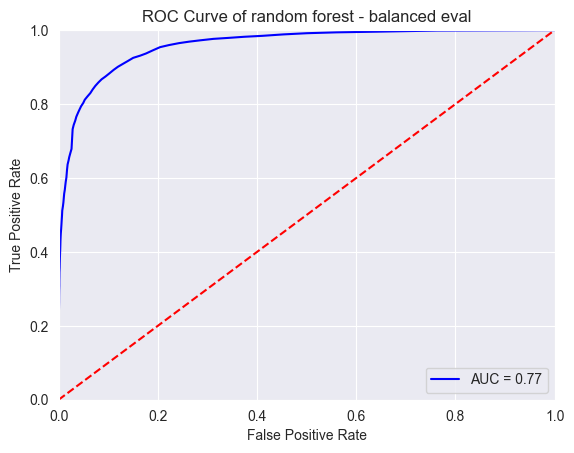

In [98]:
y_scores = rf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % auc_score)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of random forest - balanced eval')
plt.show()

In [99]:
log_reg = LogisticRegression(solver='newton-cg').fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

The line search algorithm did not converge
The line search algorithm did not converge
newton-cg failed to converge. Increase the number of iterations.


Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/700 [00:00<?, ?it/s]

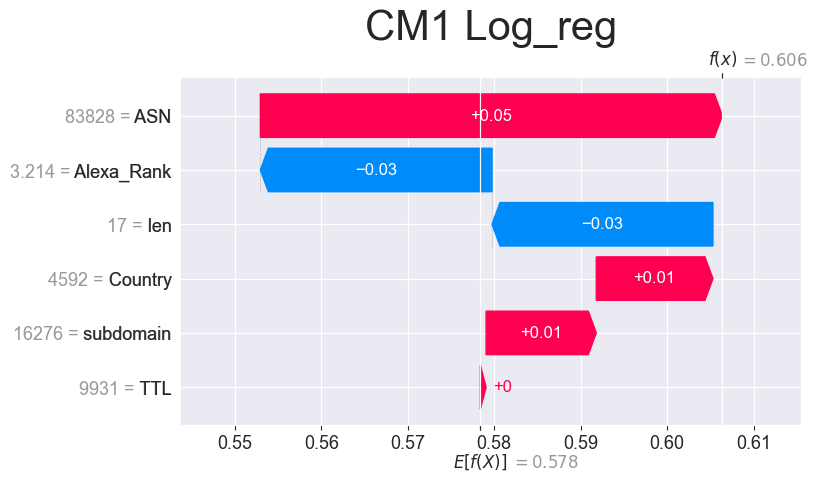

[[0.60637915 0.39362085]]


X does not have valid feature names, but LogisticRegression was fitted with feature names


In [100]:
num_samples = 700

explainer = shap.KernelExplainer(log_reg.predict_proba, X_train.iloc[:num_samples, :])
sv = explainer.shap_values(X_train.iloc[:num_samples, :])
exp = Explanation(sv[0], explainer.expected_value[0], X_train.iloc[:num_samples, :], feature_names=X.columns)

plt.title("CM1 Log_reg", fontsize=30)
idx = 0
waterfall(exp[idx])
print(log_reg.predict_proba(X_train.iloc[[idx]].values))

In [101]:
c_matrix = confusion_matrix(y_test, y_pred)

acc_score = accuracy_score(y_test, y_pred)
print('Acc_score: ', round(acc_score, 3))

auc_score = roc_auc_score(y_test, y_pred)
print('AUC-org :', round(auc_score, 3))

g_mean = geometric_mean_score(y_test, y_pred)
print('G_mean: ', round(g_mean, 3))

f1_score_val = f1_score(y_test, y_pred)
print('f1_score: ', round(f1_score_val, 3))

sensitivity = c_matrix[1, 1] / (c_matrix[1, 1] + c_matrix[1, 0])
print('Sensitivity : ', round(sensitivity, 3))

specificity = c_matrix[0, 0] / (c_matrix[0, 1] + c_matrix[0, 0])
print('Specificity : ', round(specificity, 3))

precision_score_val = precision_score(y_test, y_pred)
print('Prec-org :', round(precision_score_val, 3))

Acc_score:  0.674
AUC-org : 0.674
G_mean:  0.661
f1_score:  0.711
Sensitivity :  0.803
Specificity :  0.544
Prec-org : 0.638


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

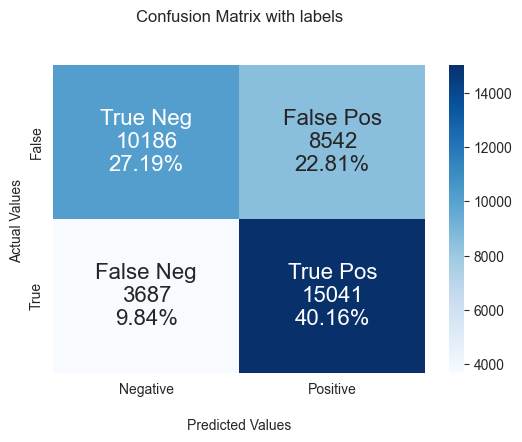

In [102]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     c_matrix.flatten() / np.sum(c_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.heatmap(c_matrix, annot=labels, cmap='Blues', fmt='', annot_kws={"size": 16})

ax.set_title('Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['False', 'True'])

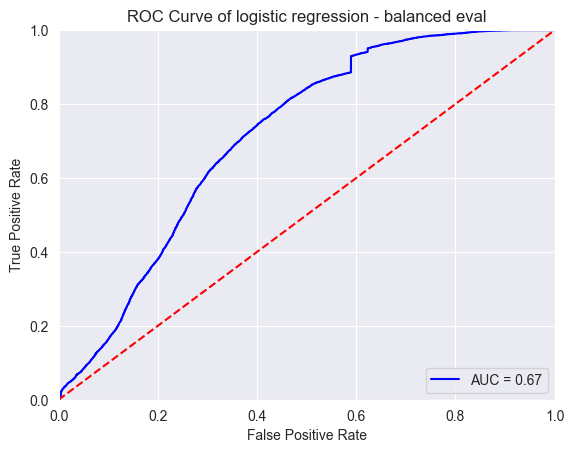

In [103]:
y_scores = log_reg.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % auc_score)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of logistic regression - balanced eval')
plt.show()

In [104]:
X_train.shape[1]

6

In [105]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=0,
    patience=20,
    mode='auto',
    restore_best_weights=True
)

verbose = 1
epochs = 8
batch_size = 64
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size,
                    validation_split=0.2)

y_pred_org = history.model.predict(X_test)

y_pred_org = y_pred_org >= 0.5

Epoch 1/8
3279/3279 [==============================] - 4s 1ms/step - loss: 918.0444 - accuracy: 0.5683 - val_loss: 457.5617 - val_accuracy: 0.2895
Epoch 2/8
3279/3279 [==============================] - 3s 1ms/step - loss: 163.6110 - accuracy: 0.5544 - val_loss: 143.2523 - val_accuracy: 0.3993
Epoch 3/8
3279/3279 [==============================] - 3s 1ms/step - loss: 65.4971 - accuracy: 0.5917 - val_loss: 87.7920 - val_accuracy: 0.3568
Epoch 4/8
3279/3279 [==============================] - 4s 1ms/step - loss: 41.2647 - accuracy: 0.5990 - val_loss: 61.6304 - val_accuracy: 0.3850
Epoch 5/8
3279/3279 [==============================] - 3s 1ms/step - loss: 29.8638 - accuracy: 0.6015 - val_loss: 39.6947 - val_accuracy: 0.4047
Epoch 6/8
3279/3279 [==============================] - 3s 1ms/step - loss: 24.6023 - accuracy: 0.6098 - val_loss: 31.5841 - val_accuracy: 0.3916
Epoch 7/8
3279/3279 [==============================] - 3s 1ms/step - loss: 21.1539 - accuracy: 0.6166 - val_loss: 27.0415 - va

22/22 [==============================] - 0s 936us/step


Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/700 [00:00<?, ?it/s]

1357/1357 [==============================] - 1s 640us/step


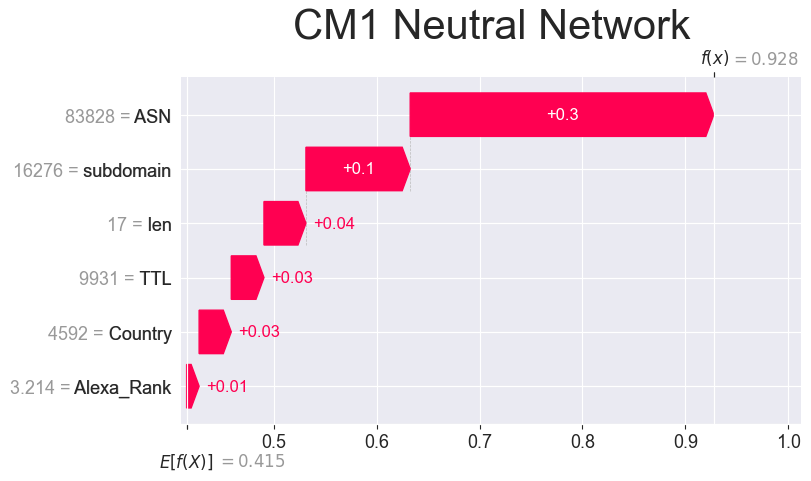

1/1 [==============================] - 0s 13ms/step
[[0.9276919]]


In [107]:
num_samples = 700

explainer = shap.KernelExplainer(history.model.predict, X_train.iloc[:num_samples, :])
sv = explainer.shap_values(X_train.iloc[:num_samples, :])
exp = Explanation(sv[0], explainer.expected_value[0], X_train.iloc[:num_samples, :], feature_names=X.columns)

plt.title("CM1 Neutral Network", fontsize=30)
idx = 0
waterfall(exp[idx])
print(history.model.predict(X_train.iloc[[idx]].values))

In [108]:
c_matrix = confusion_matrix(y_test, y_pred_org)
print('\nACC-org :', round(accuracy_score(y_test, y_pred_org), 3))
print('AUC-org :', round(roc_auc_score(y_test, y_pred_org), 3))
print('G-mean-org :', round(geometric_mean_score(y_test, y_pred_org.ravel()), 3))
print('F1-org :', round(f1_score(y_test, y_pred_org), 3))
print('Sens-org :', round(c_matrix[1, 1] / (c_matrix[1, 0] + c_matrix[1, 1]), 3))
print('Spec-org :', round(c_matrix[0, 0] / (c_matrix[0, 0] + c_matrix[0, 1]), 3))
print('Prec-org :', round(precision_score(y_test, y_pred_org), 3))
print('\nConfusion matrix\n', confusion_matrix(y_test, y_pred_org))


ACC-org : 0.537
AUC-org : 0.537
G-mean-org : 0.498
F1-org : 0.421
Sens-org : 0.336
Spec-org : 0.738
Prec-org : 0.563

Confusion matrix
 [[13830  4898]
 [12429  6299]]


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

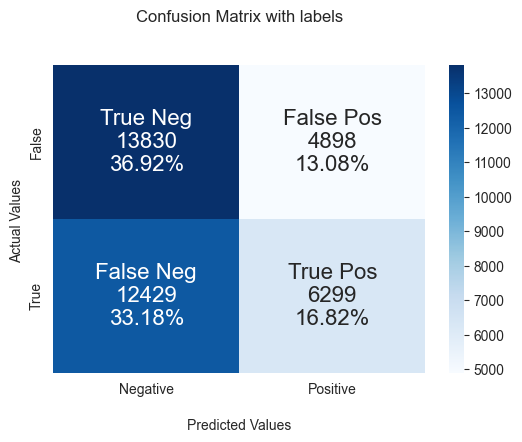

In [109]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     c_matrix.flatten() / np.sum(c_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.heatmap(c_matrix, annot=labels, cmap='Blues', fmt='', annot_kws={"size": 16})

ax.set_title('Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['False', 'True'])

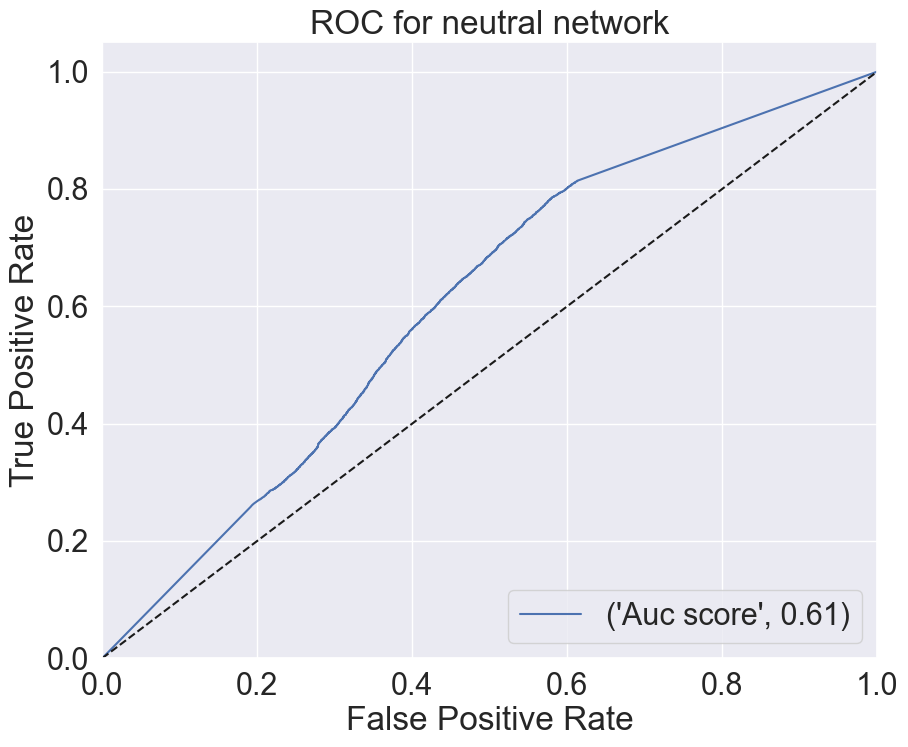

In [113]:
predictions = model.predict(X_test, verbose=0)
sns.set(font_scale=2)
fpr, tpr, _ = roc_curve(y_test, predictions)
plt.rcParams["figure.figsize"] = (10, 8)
plt.figure()
plt.plot(fpr, tpr, label=('Auc score', round(auc(fpr, tpr), 2)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for neutral network')
plt.legend(loc="lower right")
plt.show()

In [119]:
knn_validate_data_test = knn.predict(X_valid)
c_matrix = confusion_matrix(y_valid, knn_validate_data_test)
print('\nACC-org :', round(accuracy_score(y_valid, knn_validate_data_test), 3))
print('AUC-org :', round(roc_auc_score(y_valid, knn_validate_data_test), 3))
print('G-mean-org :', round(geometric_mean_score(y_valid, knn_validate_data_test.ravel()), 3))
print('F1-org :', round(f1_score(y_valid, knn_validate_data_test), 3))
print('Sens-org :', round(c_matrix[1, 1] / (c_matrix[1, 0] + c_matrix[1, 1]), 3))
print('Spec-org :', round(c_matrix[0, 0] / (c_matrix[0, 0] + c_matrix[0, 1]), 3))
print('Prec-org :', round(precision_score(y_valid, knn_validate_data_test), 3))
print('\nConfusion matrix\n', confusion_matrix(y_valid, knn_validate_data_test))


ACC-org : 0.585
AUC-org : 0.585
G-mean-org : 0.514
F1-org : 0.424
Sens-org : 0.305
Spec-org : 0.866
Prec-org : 0.695

Confusion matrix
 [[32474  5012]
 [26064 11422]]


### Model Evaluation

- **Accuracy (ACC)**: 0.585
  - The model correctly classified 58.5% of the observations, indicating a moderate ability to accurately predict the class.

- **AUC (Area under the ROC curve)**: 0.585
  - The area under the ROC curve measures the model's ability to discriminate between classes. A value of 0.585 suggests that the model has a moderate ability to discriminate between positive and negative cases.

- **G-mean (Geometric mean)**: 0.514
  - The geometric mean is a measure of the balance between sensitivity and specificity of the model. A higher value indicates a better balance between these measures.

- **F1 measure (F1-org)**: 0.424
  - F1 measure is the harmonic mean between the precision and sensitivity of the model, indicating a moderate ability to identify positive cases.

- **Sensitivity (Sens-org)**: 0.305
  - The model has a limited ability to detect 30.5% of positive cases.

- **Specificity (Spec-org)**: 0.866
  - The model has a relatively good ability to correctly identify 86.6% of negative cases.

- **Precision (Prec-org)**: 0.695
  - 69.5% of randomly classified positive cases are true.

**Confusion Matrix**:
- True Positives (TP): 11,422
- True Negatives (TN): 32,474
- False Positives (FP): 5,012
- False Negatives (FN): 26,064

The model appears to have difficulty identifying positive cases (low sensitivity), leading to a significant number of cases being falsely classified as negative. However, the model has a good ability to correctly classify negative cases (high specificity). The F1 measure (0.424) indicates that there is potential to improve the balance between precision and sensitivity.

In a production environment, further fine-tuning of the model is recommended to enhance its ability to detect positive cases (improve sensitivity). Monitoring the model's performance and taking appropriate action to optimize its performance will be crucial.

In [120]:
rf_validate_data_test = rf.predict(X_valid)
c_matrix = confusion_matrix(y_valid, rf_validate_data_test)
print('\nACC-org :', round(accuracy_score(y_valid, rf_validate_data_test), 3))
print('AUC-org :', round(roc_auc_score(y_valid, rf_validate_data_test), 3))
print('G-mean-org :', round(geometric_mean_score(y_valid, rf_validate_data_test.ravel()), 3))
print('F1-org :', round(f1_score(y_valid, rf_validate_data_test), 3))
print('Sens-org :', round(c_matrix[1, 1] / (c_matrix[1, 0] + c_matrix[1, 1]), 3))
print('Spec-org :', round(c_matrix[0, 0] / (c_matrix[0, 0] + c_matrix[0, 1]), 3))
print('Prec-org :', round(precision_score(y_valid, rf_validate_data_test), 3))
print('\nConfusion matrix\n', confusion_matrix(y_valid, rf_validate_data_test))


ACC-org : 0.771
AUC-org : 0.771
G-mean-org : 0.74
F1-org : 0.707
Sens-org : 0.552
Spec-org : 0.99
Prec-org : 0.983

Confusion matrix
 [[37119   367]
 [16775 20711]]


### Model Evaluation

- **Accuracy (ACC)**: 0.771
  - The model correctly classified 77.1% of the observations, indicating a good ability to accurately predict the class.

- **AUC (Area under the ROC curve)**: 0.771
  - The area under the ROC curve measures the model's ability to discriminate between classes. A value of 0.771 suggests that the model has a good ability to discriminate between positive and negative cases.

- **G-mean (Geometric mean)**: 0.74
  - The geometric mean is a measure of the balance between sensitivity and specificity of the model. A higher value indicates a better balance between these measures.

- **F1 measure (F1-org)**: 0.707
  - F1 measure is the harmonic mean between the precision and sensitivity of the model, indicating a fairly good ability to identify positive cases.

- **Sensitivity (Sens-org)**: 0.552
  - The model has a moderate ability to detect 55.2% of positive cases.

- **Specificity (Spec-org)**: 0.99
  - The model has a very high ability to correctly identify 99% of negative cases.

- **Precision (Prec-org)**: 0.983
  - 98.3% of randomly classified positive cases are true.

**Confusion Matrix**:
- True Positives (TP): 20,711
- True Negatives (TN): 37,119
- False Positives (FP): 367
- False Negatives (FN): 16,775

On production data, the model can be expected to have a good ability to identify positive cases (sensitivity 55.2%) and a very high ability to correctly classify negative cases (specificity 99%). The F1 measure (0.707) indicates a balanced ability of the model to identify both classes. The model is likely to be effective in detecting positive cases, but it is still worth monitoring and evaluating its performance in a production environment to adjust and optimize the model's performance.



In [121]:
log_reg_validate_data_test = log_reg.predict(X_valid)
c_matrix = confusion_matrix(y_valid, log_reg_validate_data_test)
print('\nACC-org :', round(accuracy_score(y_valid, log_reg_validate_data_test), 3))
print('AUC-org :', round(roc_auc_score(y_valid,log_reg_validate_data_test), 3))
print('G-mean-org :', round(geometric_mean_score(y_valid, log_reg_validate_data_test.ravel()), 3))
print('F1-org :', round(f1_score(y_valid, log_reg_validate_data_test), 3))
print('Sens-org :', round(c_matrix[1, 1] / (c_matrix[1, 0] + c_matrix[1, 1]), 3))
print('Spec-org :', round(c_matrix[0, 0] / (c_matrix[0, 0] + c_matrix[0, 1]), 3))
print('Prec-org :', round(precision_score(y_valid, log_reg_validate_data_test), 3))
print('\nConfusion matrix\n', confusion_matrix(y_valid, log_reg_validate_data_test))


ACC-org : 0.65
AUC-org : 0.65
G-mean-org : 0.643
F1-org : 0.68
Sens-org : 0.744
Spec-org : 0.555
Prec-org : 0.626

Confusion matrix
 [[20795 16691]
 [ 9579 27907]]


### Model Evaluation

- **Accuracy (ACC)**: 0.65
  - The model correctly classified 65% of the observations, indicating a moderately good ability to accurately predict the class.

- **AUC (Area under the ROC curve)**: 0.65
  - The area under the ROC curve measures the model's ability to discriminate between classes. A value of 0.65 suggests that the model has a moderately good ability to discriminate between positive and negative cases.

- **G-mean (Geometric mean)**: 0.643
  - The geometric mean is a measure of the balance between sensitivity and specificity of the model. A higher value indicates a better balance between these measures.

- **F1 measure (F1-org)**: 0.68
  - F1 measure is the harmonic mean between the precision and sensitivity of the model, indicating a fairly good ability to identify positive cases.

- **Sensitivity (Sens-org)**: 0.744
  - The model has a good ability to detect 74.4% of positive cases.

- **Specificity (Spec-org)**: 0.555
  - The model has a moderately good ability to correctly identify 55.5% of negative cases.

- **Precision (Prec-org)**: 0.626
  - 62.6% of randomly classified positive cases are true.

**Confusion Matrix**:
- True Positives (TP): 27,907
- True Negatives (TN): 20,795
- False Positives (FP): 16,691
- False Negatives (FN): 9,579

On production data, the model can be expected to have a moderately good ability to identify positive cases (sensitivity 74.4%) and a moderately good ability to correctly classify negative cases (specificity 55.5%). The F1 measure (0.68) suggests that the model has a balanced ability to identify both classes. It will be important to monitor and evaluate the model in a production environment to adjust and optimize its performance if necessary.


In [124]:
neutral_network_validate_data_test = history.model.predict(X_valid)
neutral_network_validate_data_test = neutral_network_validate_data_test >= 0.5

c_matrix = confusion_matrix(y_valid, neutral_network_validate_data_test)
print('\nACC-org :', round(accuracy_score(y_valid, neutral_network_validate_data_test), 3))
print('AUC-org :', round(roc_auc_score(y_valid, neutral_network_validate_data_test), 3))
print('G-mean-org :', round(geometric_mean_score(y_valid, neutral_network_validate_data_test.ravel()), 3))
print('F1-org :', round(f1_score(y_valid, neutral_network_validate_data_test), 3))
print('Sens-org :', round(c_matrix[1, 1] / (c_matrix[1, 0] + c_matrix[1, 1]), 3))
print('Spec-org :', round(c_matrix[0, 0] / (c_matrix[0, 0] + c_matrix[0, 1]), 3))
print('Prec-org :', round(precision_score(y_valid, neutral_network_validate_data_test), 3))
print('\nConfusion matrix\n', confusion_matrix(y_valid, neutral_network_validate_data_test))

2343/2343 [==============================] - 2s 657us/step

ACC-org : 0.576
AUC-org : 0.576
G-mean-org : 0.551
F1-org : 0.49
Sens-org : 0.406
Spec-org : 0.747
Prec-org : 0.616

Confusion matrix
 [[27984  9502]
 [22255 15231]]


### Model Evaluation

- **Accuracy (ACC)**: 0.576
  - The model correctly classified 57.6% of observations, indicating a moderate ability to accurately predict the class.

- **AUC (Area under the ROC curve)**: 0.576
  - The area under the ROC curve measures the model's ability to discriminate between classes. A value of 0.576 suggests a moderate ability to discriminate between positive and negative cases.

- **G-mean (Geometric mean)**: 0.551
  - The geometric mean is a measure of the balance between sensitivity and specificity of the model. A higher value indicates a better balance between these measures.

- **F1 measure (F1-org)**: 0.49
  - F1 measure is the harmonic mean between the precision and sensitivity of the model, indicating a moderate ability to identify positive cases.

- **Sensitivity (Sens-org)**: 0.406
  - The model has the ability to detect 40.6% of positive cases.

- **Specificity (Spec-org)**: 0.747
  - The model has the ability to correctly identify 74.7% of negative cases.

- **Precision (Prec-org)**: 0.616
  - 61.6% of randomly classified positive cases are true.

**Confusion Matrix**:
- True Positives (TP): 15,231
- True Negatives (TN): 27,984
- False Positives (FP): 9,502
- False Negatives (FN): 22,255

On production data, the model is expected to have a moderate ability to identify positive cases (sensitivity of 40.6%) and correctly classify negative cases (specificity of 74.7%). However, the precision of the model (61.6%) suggests that there is a risk that some cases classified as positive may be misidentified. It will be important to monitor and evaluate the model in a production environment to adjust and improve its performance.
